## Imports

In [57]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import seaborn as sns

## Environment

In [58]:
env = gym.make("Taxi-v3", render_mode = 'ansi')

env.reset()

print("Action Space {}".format(env.action_space.n))
print("State Space {}".format(env.observation_space.n))

state = env.reset()

state_ = list(env.decode(state[0]))

print(state)
print(state_)

Action Space 6
State Space 500
(407, {'prob': 1.0, 'action_mask': array([0, 1, 0, 0, 0, 0], dtype=int8)})
[4, 0, 1, 3]


## Parameters

In [59]:
alpha_smdp = 0.1
alpha_td = 0.1
gamma = 0.9

In [60]:
# epsilon greedy
def epsilon_greedy(q_values, epsilon):
    if np.random.uniform() < epsilon:
        return np.random.randint(0, len(q_values))
    else:
        return np.argmax(q_values)

In [61]:
action_option_list = ['down', 'up', 'right', 'left', 'pick', 'put', 'R', 'G', 'Y', 'B']

goal = {'R': [0, 0], 'G': [0, 4], 'Y': [4, 0], 'B': [4, 3]}

## SMDP Q Learning

In [66]:
np.random.seed(0)

# q table for SMDP and options
q_smdp = np.zeros((env.observation_space.n, 6))
q_option = {'R' : np.zeros((env.observation_space.n, env.action_space.n - 2)), 'G' : np.zeros((env.observation_space.n, env.action_space.n - 2)), 'Y' : np.zeros((env.observation_space.n, env.action_space.n - 2)), 'B' : np.zeros((env.observation_space.n, env.action_space.n - 2))}

# epsilon greedy parameters
epsilon_start = 1
epsilon_end = 0.0001
epsilon_decay = 0.99
eps = epsilon_start

episodic_rewards_list = []

for i in range(10000):
    state = env.reset()
    state = state[0]
    done = False
    episodic_reward = 0

    if i >= 9995:
        x, y, p, d = list(env.decode(state))
        print(f"Start State: {x, y, p, d}")
        print(env.render())
    
    while not done:

        action = epsilon_greedy(q_smdp[state], eps)
        eps = max(epsilon_end, eps * epsilon_decay)

        if i >= 9995:
            print("Action executed ", action_option_list[action + 4])
            
        # primitive actions - 'pick' and 'put'
        if action < 2:
            
            next_state, reward, done, terminated, _ = env.step(action + 4)
            done = done or terminated

            q_smdp[state, action] += alpha_smdp * (reward + gamma * np.max(q_smdp[next_state]) - q_smdp[state, action])
            state = next_state
            episodic_reward += reward
            if i >= 9995:
                print(env.render())

        # options - 'R', 'G', 'Y', 'B'
        else:
            option = action_option_list[action + 4]
            option_done = False
            option_reward = 0
            reward_bar = 0
            tau = 0
            state_start = state

            while not option_done:
                
                optact = epsilon_greedy(q_option[option][state], eps)

                next_state, reward, done, terminated, _ = env.step(optact)
                done = done or terminated
                x, y, _, _ = list(env.decode(next_state))
                if [x, y] == goal[option]:
                    option_done = True
                option_reward += reward
                # TD update
                q_option[option][state, optact] += alpha_td * (reward + gamma * np.max(q_option[option][next_state]) - q_option[option][state, optact])
                
                reward_bar = reward_bar + gamma**(tau) * reward
                tau += 1
                
                state = next_state
                episodic_reward += reward
                if i >= 9995:
                    print(env.render())
                if done:
                    break
                    
            # SMDP update
            q_smdp[state_start, action] += alpha_smdp * (reward_bar + gamma**(tau) * np.max(q_smdp[state]) - q_smdp[state_start, action])
            
    episodic_rewards_list.append(episodic_reward)
    print("Episode {} Reward {}".format(i, episodic_reward))

Episode 0 Reward -209
Episode 1 Reward -218
Episode 2 Reward -209
Episode 3 Reward -236
Episode 4 Reward -218
Episode 5 Reward -209
Episode 6 Reward -209
Episode 7 Reward -227
Episode 8 Reward -227
Episode 9 Reward -227
Episode 10 Reward -227
Episode 11 Reward -200
Episode 12 Reward -200
Episode 13 Reward -227
Episode 14 Reward -254
Episode 15 Reward -209
Episode 16 Reward -218
Episode 17 Reward -218
Episode 18 Reward -236
Episode 19 Reward -254
Episode 20 Reward -227
Episode 21 Reward -236
Episode 22 Reward -200
Episode 23 Reward -200
Episode 24 Reward -218
Episode 25 Reward -236
Episode 26 Reward -218
Episode 27 Reward -200
Episode 28 Reward -218
Episode 29 Reward -218
Episode 30 Reward -209
Episode 31 Reward -236
Episode 32 Reward -254
Episode 33 Reward -218
Episode 34 Reward -245
Episode 35 Reward -218
Episode 36 Reward -227
Episode 37 Reward -227
Episode 38 Reward -236
Episode 39 Reward -218
Episode 40 Reward -254
Episode 41 Reward -245
Episode 42 Reward -218
Episode 43 Reward -21

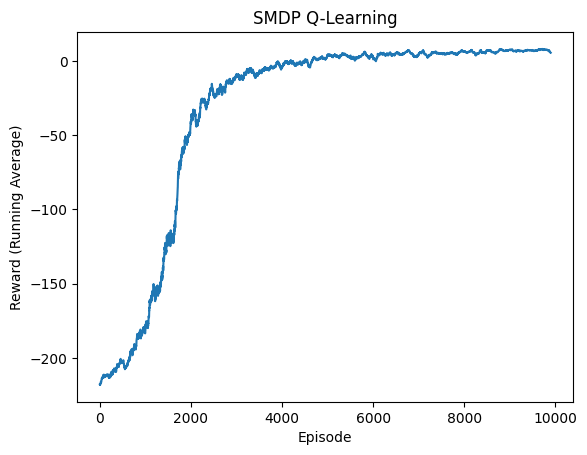

In [74]:
avg_rews2 = [np.average(episodic_rewards_list[i:i+100]) for i in range(len(episodic_rewards_list)-100)]
plt.plot(avg_rews2)
plt.xlabel("Episode")
plt.ylabel("Reward (Running Average)")
# plt.axhline(y=5, color='r', linestyle='-')
plt.title("SMDP Q-Learning")
plt.savefig("SMDP_reward")
plt.show()


### Visualizing the Q values

In [77]:
policy = np.zeros((5, 5))

pas = 3
des = 2

for i in range(500):
    x, y, p, d = list(env.decode(i))
    # if x == 1 and y == 1 and p == 1 and d == 2:
    #     print(q_smdp[i])
    if p == pas and d == des:
        policy[x, y] = np.argmax(q_smdp[i])
        if all(q_smdp[i] == 0):
            policy[x, y] = -1.0

policy

array([[5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5.],
       [5., 5., 5., 0., 5.]])

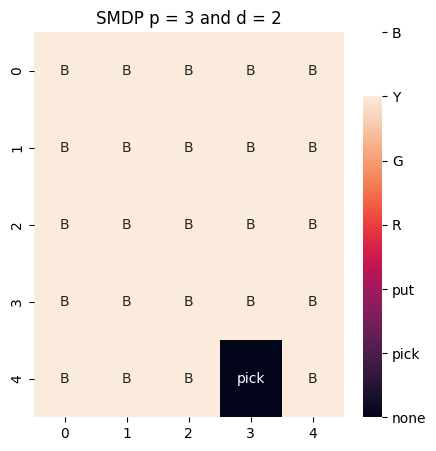

In [78]:
figure, axis = plt.subplots(1, 1, figsize=(5, 5))

labels = {-1: 'none', 0: 'pick', 1: 'put', 2: 'R', 3: 'G', 4: 'Y', 5: 'B'}
annot_text = np.vectorize(labels.get)(policy)
ax = sns.heatmap(policy,ax=axis,annot = annot_text,fmt='')
axis.set_title(f"SMDP p = {pas} and d = {des}")
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([i for i in range(7)])
c_bar.set_ticklabels(['none', 'pick', 'put', 'R', 'G', 'Y', 'B'])

### Option's Policy

In [97]:
policy = np.zeros((5, 5))

pas = 4
des = 2
opti = 'B'

for i in range(500):
    x, y, p, d = list(env.decode(i))
    if p == pas and d == des:
        policy[x, y] = np.argmax(q_option["Y"][i])
        
policy

array([[0., 0., 0., 0., 3.],
       [0., 2., 0., 3., 0.],
       [0., 3., 3., 3., 3.],
       [0., 3., 0., 1., 1.],
       [0., 2., 3., 1., 1.]])

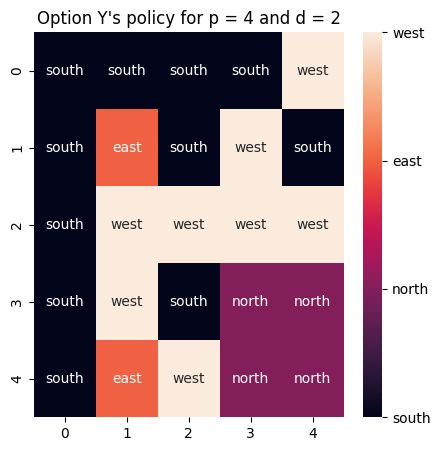

In [98]:
figure, axis = plt.subplots(1, 1, figsize=(5, 5))

labels = {0:'south',1:'north', 2:'east', 3:'west'}
annot_text = np.vectorize(labels.get)(policy)
ax = sns.heatmap(policy,ax=axis,annot = annot_text,fmt='')
axis.set_title(f"Option Y's policy for p = {pas} and d = {des}")
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([i for i in range(4)])
c_bar.set_ticklabels(['south','north','east','west'])

## Intra Option Q Learning

In [160]:
np.random.seed(0)

# q table for intra option and options
q_ioql = np.zeros((env.observation_space.n, 6))
q_option_ioql = {'R' : np.zeros((env.observation_space.n, env.action_space.n - 2)), 'G' : np.zeros((env.observation_space.n, env.action_space.n - 2)), 'Y' : np.zeros((env.observation_space.n, env.action_space.n - 2)), 'B' : np.zeros((env.observation_space.n, env.action_space.n - 2))}

# parameters
gamma_ioql = 0.9
gamma_policy = 0.9
alpha_ioql = 0.1

# epsilon greedy parameters
epsilon_ioql = 1
epsilon_opt = 1
episodic_rewards_list_ioql = []
eps_min = 0.0001
eps_decay = 0.99

for i in range(10000):
    state = env.reset()
    state = state[0]
    done = False
    episodic_reward = 0

    if i >= 9995:
        x, y, p, d = list(env.decode(state))
        print(x, y, p, d)
        print("Start State")

    while not done:
        epsilon_ioql = max(eps_min,eps_decay*epsilon_ioql)
        epsilon_opt = max(eps_min,eps_decay*epsilon_opt)

        action = epsilon_greedy(q_ioql[state], epsilon_ioql)

        if i >=9995:
            print("Action executed", action_option_list[action + 4])

        # primitive actions
        if action < 2:
            
            next_state, reward, done, terminated, _= env.step(action + 4)
            done = done or terminated
            x, y, _, _ = list(env.decode(next_state))
            q_ioql[state, action] += alpha_ioql * (reward + gamma_ioql * np.max(q_ioql[next_state]) - q_ioql[state, action])
            
            state = next_state
            episodic_reward += reward
            if i >= 9995:
                print(env.render())

        # options - 'R', 'G', 'Y', 'B'
        else:
            option = action_option_list[action + 4]
            init_state = state
            option_done = False

            while (option_done == False):

                optact = epsilon_greedy(q_option_ioql[option][state], epsilon_opt)
                next_state, reward, done, terminated, _ = env.step(optact)
                done = done or terminated
                x, y, _, _ = list(env.decode(next_state))
                if [x, y] == goal[option]:
                    option_done = True
    
                for idx in [2, 3, 4, 5]:
                    opt = action_option_list[idx + 4]
                    
                    # intra option Q learning update
                    if [x, y] == goal[opt]:
                        q_option_ioql[opt][state, optact] += alpha_td * (reward + gamma_policy * np.max(q_option_ioql[opt][next_state]) - q_option_ioql[opt][state, optact])
                        q_ioql[state, idx] += alpha_ioql * (reward + gamma_ioql * np.max(q_ioql[next_state]) - q_ioql[state, idx])
                    else:
                        q_option_ioql[opt][state, optact] += alpha_td * (reward + gamma_policy * np.max(q_option_ioql[opt][next_state]) - q_option_ioql[opt][state, optact])
                        q_ioql[state, idx] += alpha_ioql * (reward + gamma_ioql * (q_ioql[next_state][idx]) - q_ioql[state, idx])

                state = next_state
                episodic_reward += reward
                if i >= 9995:
                    print(env.render())
                if done:
                    break

    episodic_rewards_list_ioql.append(episodic_reward)
    print(f"Episode {i}: Reward = {episodic_reward}")


Episode 0: Reward = -209
Episode 1: Reward = -209
Episode 2: Reward = -209
Episode 3: Reward = -200
Episode 4: Reward = -200
Episode 5: Reward = -200
Episode 6: Reward = -209
Episode 7: Reward = -227
Episode 8: Reward = -209
Episode 9: Reward = -245
Episode 10: Reward = -227
Episode 11: Reward = -200
Episode 12: Reward = -209
Episode 13: Reward = -236
Episode 14: Reward = -236
Episode 15: Reward = -218
Episode 16: Reward = -236
Episode 17: Reward = -236
Episode 18: Reward = -227
Episode 19: Reward = -236
Episode 20: Reward = -227
Episode 21: Reward = -227
Episode 22: Reward = -272
Episode 23: Reward = -308
Episode 24: Reward = -236
Episode 25: Reward = -218
Episode 26: Reward = -245
Episode 27: Reward = -272
Episode 28: Reward = -272
Episode 29: Reward = -245
Episode 30: Reward = -218
Episode 31: Reward = -254
Episode 32: Reward = -218
Episode 33: Reward = -245
Episode 34: Reward = -290
Episode 35: Reward = -245
Episode 36: Reward = -218
Episode 37: Reward = -254
Episode 38: Reward = -

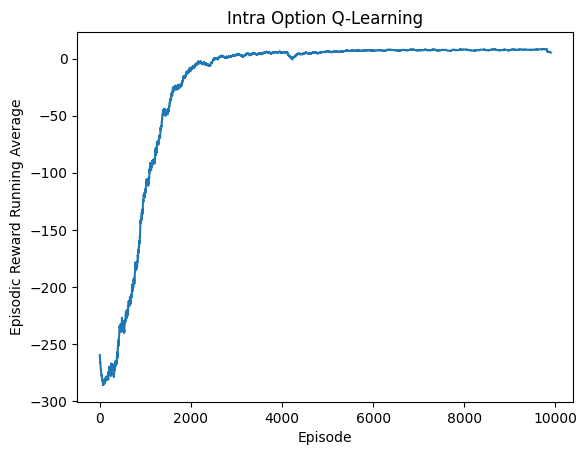

In [161]:
episodic_rewards_list_ioql = np.array(episodic_rewards_list_ioql)
avg_rews2 = [np.average(episodic_rewards_list_ioql[i:i+100]) for i in range(len(episodic_rewards_list_ioql)-100)]

plt.figure()
plt.plot(avg_rews2, label='IOQL')
plt.xlabel('Episode')
# plt.axhline(8.5, color ='r')
plt.ylabel('Episodic Reward Running Average')
plt.title("Intra Option Q-Learning")
# plt.legend()
plt.savefig("IOQL_reward")
plt.show()

### Visualizing the Q values

In [163]:
policy = np.zeros((5, 5))
pa = 4
de = 2
for i in range(500):
    x, y, p, d = list(env.decode(i))
    if p == pa and d == de:
        policy[x, y] = np.argmax(q_ioql[i])
        if all(q_ioql[i] == 0):
            policy[x, y] = -1.0
        print(q_ioql[i])
        
policy

[-8.64827525 -8.2508676  -9.55791403 -9.5718335   9.683      -9.57213857]
[ 0.          0.         -6.83360637 -9.75796802 -3.03414335 -9.75864848]
[ 0.          0.         -9.64191038 -9.65318513  5.94322918 -9.65343226]
[ 0.          0.         -9.67771934 -9.68786661  4.34890618 -9.68808903]
[-10.22616868  -9.66990159  -9.70994742  -9.71907994   2.91401526
  -9.71928013]
[ 0.          0.         -9.50879337 -9.52425944 11.87       -9.52459841]
[ 0.          0.         -9.01764364 -9.68378378  1.42266971 -9.68443086]
[ 0.          0.         -9.60212263 -9.61465015  7.7147     -9.61492471]
[ 0.          0.         -9.64191036 -9.65318513  5.94323    -9.65343224]
[ 0.          0.         -9.67771935 -9.6878666   4.34890608 -9.68808903]
[ 0.          0.         -9.45421485 -9.47139938 14.3        -9.47177601]
[ 0.          0.         -9.50879337 -9.52425944 11.87       -9.52459841]
[ 0.          0.         -9.55791403 -9.5718335   9.683      -9.57213857]
[ 0.          0.         -9.602

array([[4., 0., 4., 4., 4.],
       [4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4.],
       [4., 0., 0., 4., 0.],
       [1., 0., 0., 4., 0.]])

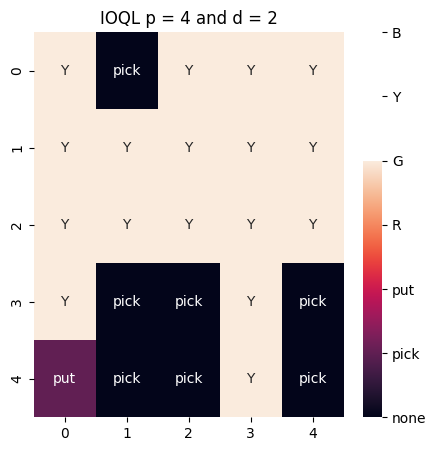

In [164]:
figure, axis = plt.subplots(1, 1, figsize=(5, 5))

labels = {-1: 'none', 0: 'pick', 1: 'put', 2: 'R', 3: 'G', 4: 'Y', 5: 'B'}
annot_text = np.vectorize(labels.get)(policy)
ax = sns.heatmap(policy,ax=axis,annot = annot_text,fmt='')
axis.set_title(f"IOQL p = {pa} and d = {de}")
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([i for i in range(7)])
c_bar.set_ticklabels(['none', 'pick', 'put', 'R', 'G', 'Y', 'B'])

### Option's Policy

In [116]:
policy = np.zeros((5, 5))

for i in range(500):
    x, y, p, d = list(env.decode(i))
    if p == 4 and d == 1:
        policy[x, y] = np.argmax(q_option_ioql['G'][i])
        
policy

array([[2., 0., 2., 2., 3.],
       [0., 0., 1., 1., 1.],
       [2., 2., 1., 1., 1.],
       [1., 3., 2., 1., 1.],
       [1., 0., 0., 1., 1.]])

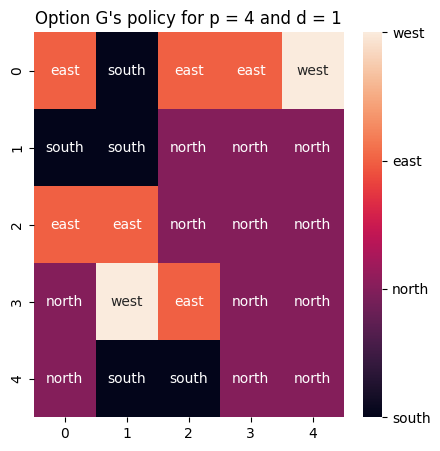

In [118]:
figure, axis = plt.subplots(1, 1, figsize=(5, 5))

labels = {0:'south',1:'north', 2:'east', 3:'west'}
annot_text = np.vectorize(labels.get)(policy)
ax = sns.heatmap(policy,ax=axis,annot = annot_text,fmt='')
axis.set_title("Option G's policy for p = 4 and d = 1")
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([i for i in range(4)])
c_bar.set_ticklabels(['south','north','east','west'])

### Comparing SMDP Q learning and Intra Option Q learning

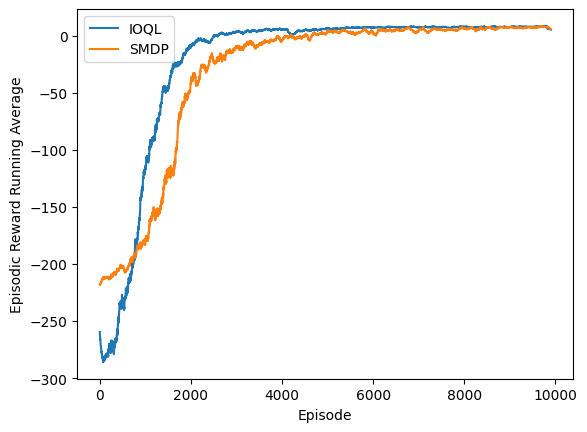

In [ ]:
episodic_rewards_list_ioql = np.array(episodic_rewards_list_ioql)
avg_rews1 = [np.average(episodic_rewards_list[i:i+100]) for i in range(len(episodic_rewards_list)-100)]
avg_rews2 = [np.average(episodic_rewards_list_ioql[i:i+100]) for i in range(len(episodic_rewards_list_ioql)-100)]

plt.figure()
plt.plot(avg_rews2, label='IOQL')
plt.plot(avg_rews1, label='SMDP')
plt.xlabel('Episode')
# plt.axhline(8.5, color ='r')
plt.ylabel('Episodic Reward Running Average')
# plt.title("Intra Option Q-Learning")
plt.legend()
plt.savefig("Compare_reward")
plt.show()

## Alternate Options

In [165]:
action_option_list_new = ['down', 'up', 'right', 'left', 'pick', 'put', 'go to passenger', 'go to destination']

goal_new = {0: [0, 0], 1: [0, 4], 2: [4, 0], 3: [4, 3]}

### SMDP Q Learning

In [170]:
np.random.seed(0)

q_smdp = np.zeros((env.observation_space.n, 4))
q_option = {'go to passenger' : np.zeros((env.observation_space.n, env.action_space.n - 2)), 'go to destination' : np.zeros((env.observation_space.n, env.action_space.n - 2))}

epsilon_start = 1
epsilon_end = 0.0001
epsilon_decay = 0.99
eps = epsilon_start

episodic_rewards_list = []

for i in range(10000):
    state = env.reset()
    state = state[0]
    done = False
    episodic_reward = 0

    if i >= 9995:
        x, y, p, d = list(env.decode(state))
        print(x, y, p, d)
        print("Starting State")
        print(env.render())
    
    while not done:
        
        action = epsilon_greedy(q_smdp[state], eps)
        eps = max(epsilon_end, eps * epsilon_decay)

        if i >= 9995:
            print("Action executed ", action_option_list_new[action + 4])

        if action < 2:
            
            next_state, reward, done, terminated, _ = env.step(action + 4)
            done = done or terminated

            q_smdp[state, action] += alpha_smdp * (reward + gamma * np.max(q_smdp[next_state]) - q_smdp[state, action])
            state = next_state
            episodic_reward += reward
            if i >= 9995:
                print(env.render())

        else:
            option = action_option_list_new[action + 4]
            option_done = False
            option_reward = 0
            reward_bar = 0
            tau = 0
            state_start = state

            while not option_done:
                
                optact = epsilon_greedy(q_option[option][state], eps)

                next_state, reward, done, terminated, _ = env.step(optact)
                done = done or terminated
                x, y, p, d = list(env.decode(next_state))
                if p != 4 and goal_new[p] == [x, y] and option == 'go to passenger':
                    option_done = True
                if p == 4 and goal_new[d] == [x, y] and option == 'go to destination':
                    option_done = True
                option_reward += reward
                q_option[option][state, optact] += alpha_td * (reward + gamma * np.max(q_option[option][next_state]) - q_option[option][state, optact])
                
                reward_bar = reward_bar + gamma**(tau) * reward
                tau += 1
                
                state = next_state
                episodic_reward += reward
                if i >= 9995:
                    print(env.render())
                if done:
                    break
                    
            q_smdp[state_start, action] += alpha_smdp * (reward_bar + gamma**(tau) * np.max(q_smdp[state]) - q_smdp[state_start, action])
            
    episodic_rewards_list.append(episodic_reward)
    print("Episode {} Reward {}".format(i, episodic_reward))

Episode 0 Reward -209
Episode 1 Reward -200
Episode 2 Reward -183
Episode 3 Reward -209
Episode 4 Reward -200
Episode 5 Reward -200
Episode 6 Reward -209
Episode 7 Reward -200
Episode 8 Reward -218
Episode 9 Reward -209
Episode 10 Reward -218
Episode 11 Reward -236
Episode 12 Reward -236
Episode 13 Reward -245
Episode 14 Reward -209
Episode 15 Reward -209
Episode 16 Reward -227
Episode 17 Reward -218
Episode 18 Reward -236
Episode 19 Reward -209
Episode 20 Reward -218
Episode 21 Reward -209
Episode 22 Reward -245
Episode 23 Reward -209
Episode 24 Reward -245
Episode 25 Reward -227
Episode 26 Reward -209
Episode 27 Reward -245
Episode 28 Reward -218
Episode 29 Reward -245
Episode 30 Reward -218
Episode 31 Reward -218
Episode 32 Reward -227
Episode 33 Reward -200
Episode 34 Reward -200
Episode 35 Reward -218
Episode 36 Reward -200
Episode 37 Reward -218
Episode 38 Reward -227
Episode 39 Reward -227
Episode 40 Reward -218
Episode 41 Reward -218
Episode 42 Reward -218
Episode 43 Reward -22

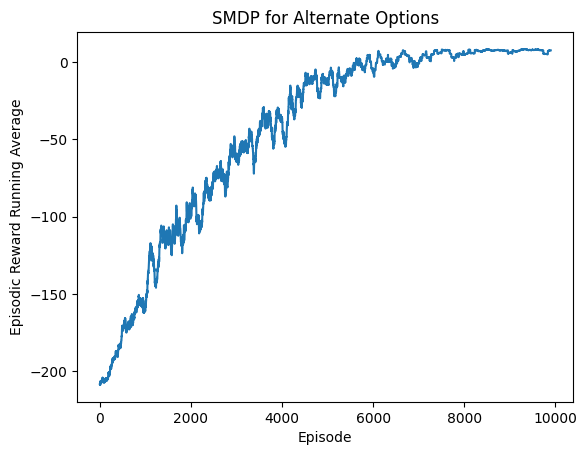

In [168]:
episodic_rewards_list = np.array(episodic_rewards_list)
avg_rews2 = [np.average(episodic_rewards_list[i:i+100]) for i in range(len(episodic_rewards_list)-100)]

plt.figure()
plt.plot(avg_rews2, label='SMDP')
plt.xlabel('Episode')
# plt.axhline(8.5, color ='r')
plt.ylabel('Episodic Reward Running Average')
# plt.legend()
plt.title("SMDP for Alternate Options")
plt.savefig("SMDPAltReward")
plt.show()

#### Visualizing the Q values

In [175]:
policy = np.zeros((5, 5))

pas = 4
des = 0

for i in range(500):
    x, y, p, d = list(env.decode(i))
    # if x == 1 and y == 1 and p == 1 and d == 2:
    #     print(q_smdp[i])
    if p == pas and d == des:
        policy[x, y] = np.argmax(q_smdp[i])
        if all(q_smdp[i] == 0):
            policy[x, y] = -1.0

policy

array([[ 1., -1., -1., -1.,  3.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [ 3., -1., -1.,  3., -1.]])

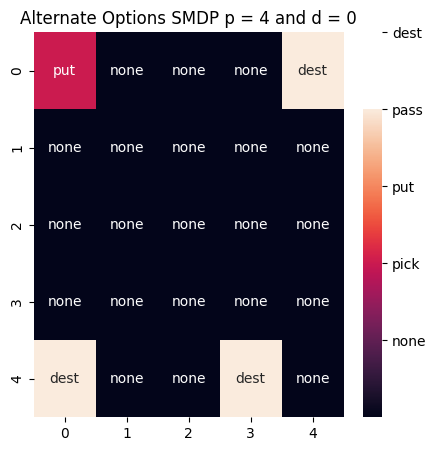

In [176]:
figure, axis = plt.subplots(1, 1, figsize=(5, 5))

labels = {-1: 'none', 0: 'pick', 1: 'put', 2: 'pass', 3: 'dest'}
annot_text = np.vectorize(labels.get)(policy)
ax = sns.heatmap(policy,ax=axis,annot = annot_text,fmt='')
axis.set_title(f"Alternate Options SMDP p = {pas} and d = {des}")
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([i for i in range(5)])
c_bar.set_ticklabels(['none', 'pick', 'put', 'pass', 'dest'])

#### Option's Policy

In [180]:
policy = np.zeros((5, 5))

pas = 2
des = 0

for i in range(500):
    x, y, p, d = list(env.decode(i))
    if p == pas and d == des:
        policy[x, y] = np.argmax(q_option['go to passenger'][i])
        
policy

array([[0., 3., 0., 3., 0.],
       [0., 1., 0., 0., 3.],
       [0., 3., 3., 3., 3.],
       [0., 1., 1., 1., 3.],
       [0., 1., 0., 1., 1.]])

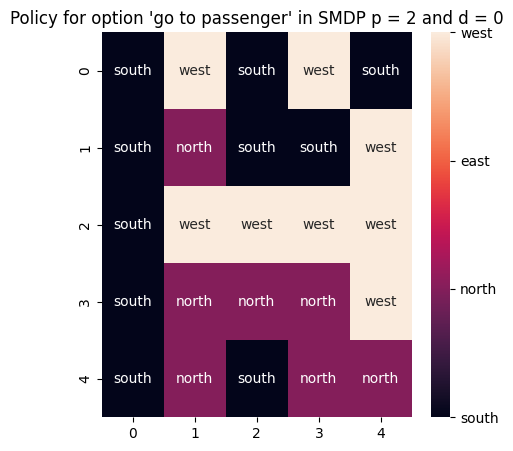

In [181]:
figure, axis = plt.subplots(1, 1, figsize=(5, 5))

labels = {0:'south',1:'north', 2:'east', 3:'west'}
annot_text = np.vectorize(labels.get)(policy)
ax = sns.heatmap(policy,ax=axis,annot = annot_text,fmt='')
axis.set_title(f"Policy for option 'go to passenger' in SMDP p = {pas} and d = {des}")
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([i for i in range(4)])
c_bar.set_ticklabels(['south','north','east','west'])

### Intra Option Q Learning

In [186]:

np.random.seed(0)

q_ioql = np.zeros((env.observation_space.n, 4))
q_option_ioql = {'go to passenger' : np.zeros((env.observation_space.n, env.action_space.n - 2)), 'go to destination' : np.zeros((env.observation_space.n, env.action_space.n - 2))}
gamma_ioql = 0.9
gamma_policy = 0.9
alpha_ioql = 0.1
epsilon_ioql = 1
epsilon_opt = 1
episodic_rewards_list_ioql = []
eps_min = 0.0001
eps_decay = 0.99

for i in range(10000):
    state = env.reset()
    state = state[0]
    done = False
    episodic_reward = 0

    if i >= 9995:
        x, y, p, d = list(env.decode(state))
        print(x, y, p, d)
        print("Starting State")
        print(env.render())

    while not done:
        epsilon_ioql = max(eps_min,eps_decay*epsilon_ioql)
        epsilon_opt = max(eps_min,eps_decay*epsilon_opt)

        action = epsilon_greedy(q_ioql[state], epsilon_ioql)

        if i >=9995:
            print("Action executed", action_option_list_new[action + 4])

        if action < 2:
            
            next_state, reward, done, terminated, _= env.step(action + 4)
            done = done or terminated
            x, y, _, _ = list(env.decode(next_state))
            q_ioql[state, action] += alpha_ioql * (reward + gamma_ioql * np.max(q_ioql[next_state]) - q_ioql[state, action])
            
            state = next_state
            episodic_reward += reward
            if i >= 9995:
                print(env.render())

        else:
            option = action_option_list_new[action + 4]
            init_state = state
            option_done = False

            while (option_done == False):

                optact = epsilon_greedy(q_option_ioql[option][state], epsilon_opt)
                next_state, reward, done, terminated, _ = env.step(optact)
                done = done or terminated
                x, y, p, d = list(env.decode(next_state))
                if p != 4 and goal_new[p] == [x, y] and option == 'go to passenger':
                    option_done = True
                if p == 4 and goal_new[d] == [x, y] and option == 'go to destination':
                    option_done = True
                    
                for idx in [2, 3]:
                    opt = action_option_list_new[idx + 4]

                    if (p != 4 and goal_new[p] == [x, y] and opt == 'go to passenger') or (p == 4 and goal_new[d] == [x, y] and opt == 'go to destination'):

                        q_option_ioql[opt][state, optact] += alpha_td * (reward + gamma_policy * np.max(q_option_ioql[opt][next_state]) - q_option_ioql[opt][state, optact])
                        q_ioql[state, idx] += alpha_ioql * (reward + gamma_ioql * np.max(q_ioql[next_state]) - q_ioql[state, idx])
                    else:

                        q_option_ioql[opt][state, optact] += alpha_td * (reward + gamma_policy * np.max(q_option_ioql[opt][next_state]) - q_option_ioql[opt][state, optact])
                        q_ioql[state, idx] += alpha_ioql * (reward + gamma_ioql * (q_ioql[next_state][idx]) - q_ioql[state, idx])

                state = next_state
                episodic_reward += reward
                if i >= 9995:
                    print(env.render())
                if done:
                    break

    episodic_rewards_list_ioql.append(episodic_reward)
    print(f"Episode {i}: Reward = {episodic_reward}")

Episode 0: Reward = -209
Episode 1: Reward = -200
Episode 2: Reward = -227
Episode 3: Reward = -200
Episode 4: Reward = -200
Episode 5: Reward = -200
Episode 6: Reward = -209
Episode 7: Reward = -172
Episode 8: Reward = -227
Episode 9: Reward = -227
Episode 10: Reward = -218
Episode 11: Reward = -209
Episode 12: Reward = -209
Episode 13: Reward = -209
Episode 14: Reward = -200
Episode 15: Reward = -227
Episode 16: Reward = -200
Episode 17: Reward = -218
Episode 18: Reward = -245
Episode 19: Reward = -209
Episode 20: Reward = -254
Episode 21: Reward = -245
Episode 22: Reward = -245
Episode 23: Reward = -209
Episode 24: Reward = -106
Episode 25: Reward = -227
Episode 26: Reward = -218
Episode 27: Reward = -227
Episode 28: Reward = -254
Episode 29: Reward = -209
Episode 30: Reward = -227
Episode 31: Reward = -200
Episode 32: Reward = -137
Episode 33: Reward = -36
Episode 34: Reward = -218
Episode 35: Reward = -254
Episode 36: Reward = -254
Episode 37: Reward = -209
Episode 38: Reward = -2

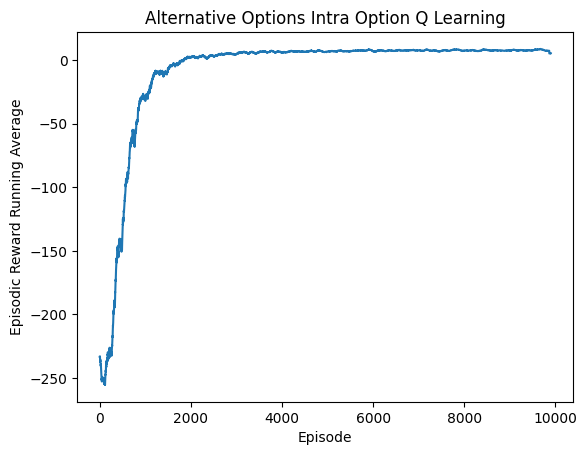

In [189]:
episodic_rewards_list_ioql = np.array(episodic_rewards_list_ioql)
avg_rews2 = [np.average(episodic_rewards_list_ioql[i:i+100]) for i in range(len(episodic_rewards_list_ioql)-100)]

plt.figure()
plt.plot(avg_rews2, label='IOQL')
plt.xlabel('Episode')
# plt.axhline(8.5, color ='r')
plt.ylabel('Episodic Reward Running Average')
plt.title("Alternative Options Intra Option Q Learning")
# plt.legend()
plt.savefig("ioql_alt_reward")
plt.show()

#### Visualizing the Q values

In [193]:
policy = np.zeros((5, 5))

pas = 4
des = 1

for i in range(500):
    x, y, p, d = list(env.decode(i))
    # if x == 1 and y == 1 and p == 1 and d == 2:
    #     print(q_smdp[i])
    if p == pas and d == des:
        policy[x, y] = np.argmax(q_ioql[i])
        if all(q_ioql[i] == 0):
            policy[x, y] = -1.0

policy

array([[3., 3., 3., 3., 1.],
       [3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3.],
       [3., 0., 0., 3., 3.],
       [3., 0., 0., 3., 3.]])

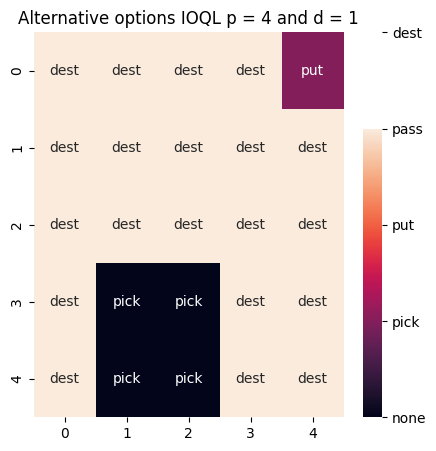

In [194]:
figure, axis = plt.subplots(1, 1, figsize=(5, 5))

labels = {-1: 'none', 0: 'pick', 1: 'put', 2: 'pass', 3: 'dest'}
annot_text = np.vectorize(labels.get)(policy)
ax = sns.heatmap(policy,ax=axis,annot = annot_text,fmt='')
axis.set_title(f"Alternative options IOQL p = {pas} and d = {des}")
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([i for i in range(5)])
c_bar.set_ticklabels(['none', 'pick', 'put', 'pass', 'dest'])

#### Option's Policy

In [197]:
policy = np.zeros((5, 5))

pas = 4
des = 1

for i in range(500):
    x, y, p, d = list(env.decode(i))
    if p == pas and d == des:
        policy[x, y] = np.argmax(q_option_ioql['go to destination'][i])
        
policy
        
policy

array([[0., 0., 2., 2., 1.],
       [0., 0., 1., 1., 1.],
       [2., 2., 1., 1., 1.],
       [1., 0., 2., 2., 1.],
       [1., 2., 0., 2., 1.]])

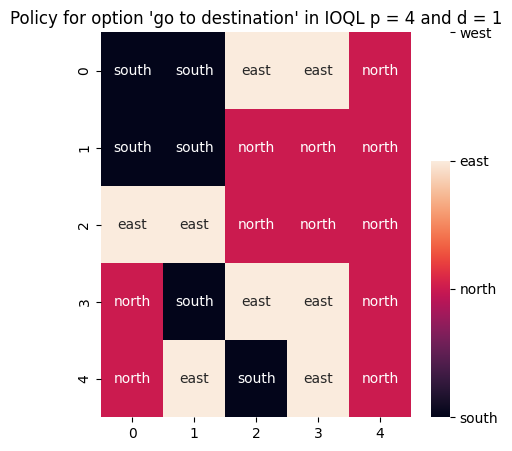

In [198]:
figure, axis = plt.subplots(1, 1, figsize=(5, 5))

labels = {0:'south',1:'north', 2:'east', 3:'west'}
annot_text = np.vectorize(labels.get)(policy)
ax = sns.heatmap(policy,ax=axis,annot = annot_text,fmt='')
axis.set_title(f"Policy for option 'go to destination' in IOQL p = {pas} and d = {des}")
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([i for i in range(4)])
c_bar.set_ticklabels(['south','north','east','west'])

### Comparing SMDP Q learning and Intra Option Q learning for the chosen alternate options

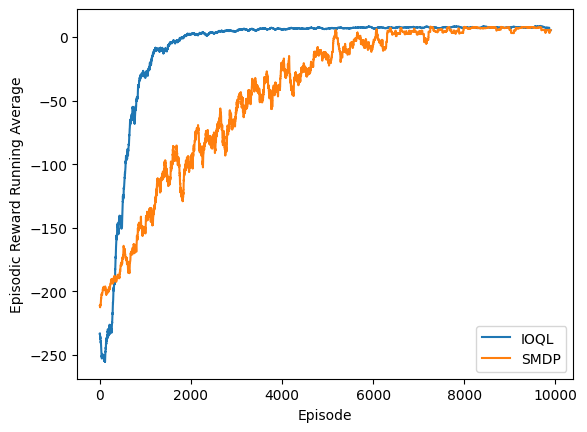

In [ ]:
episodic_rewards_list_ioql = np.array(episodic_rewards_list_ioql)
avg_rews1 = [np.average(episodic_rewards_list[i:i+100]) for i in range(len(episodic_rewards_list)-100)]
avg_rews2 = [np.average(episodic_rewards_list_ioql[i:i+100]) for i in range(len(episodic_rewards_list_ioql)-100)]

plt.figure()
plt.plot(avg_rews2, label='IOQL')
plt.plot(avg_rews1, label='SMDP')
plt.xlabel('Episode')
# plt.axhline(8.5, color ='r')
plt.ylabel('Episodic Reward Running Average')
# plt.title("Intra Option Q-Learning")
plt.legend()
plt.savefig("Compare_reward_alt")
plt.show()